In [ ]:
import pyemu
import conda_scripts.load_datasets as lsd
import os
import pandas as pd
import numpy as np
import conda_scripts
import forward_run

In [ ]:
workspace = lsd.model_info.get_mod('son', True)
workspace

# create a local copy without git folders

In [ ]:
import shutil
from shutil import ignore_patterns



# Define the source and destination folders
src_folder = workspace
dest_folder = 'local_copy'

if not os.path.exists(dest_folder):
    pass
else:
    print('erasing dest_folder')
    pyemu.os.remove(dest_folder)

# Copy the directory tree from src to dest, ignoring the .git directory
shutil.copytree(src_folder, dest_folder, ignore=ignore_patterns('.git', '.git/*'))
workspace = dest_folder

In [ ]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("pestaws_V2")

In [ ]:

start_datetime="12-1-1969"
# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=workspace, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=False, # set False if using PEST/PEST_HP
                            # spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime=start_datetime, # required when specifying temporal correlation between parameters
                            echo=False) # to stop PstFrom from writting lots of infromation to the notebook; experiment by setting it as True to see the difference; usefull for troubleshooting



In [ ]:
ml = conda_scripts.sv_budget.load_sv_model.get_model(template_ws)

In [ ]:
if os.path.exists(os.path.join(template_ws, 'pp2024')):
    pass
else:
    os.mkdir(os.path.join(template_ws, 'pp2024'))

if os.path.exists(os.path.join(template_ws, 'pp2024_out')):
    pass
else:
    os.mkdir(os.path.join(template_ws, 'pp2024_out'))

if not os.path.exists(os.path.join(template_ws, '.git')):
    pass
else:
    print('erasing git')
    pyemu.os.remove(os.path.join(template_ws, '.git'))


In [ ]:
# def summarize_budget(folder):
#     b = os.path.join(folder,'output',"Budget.txt")
#     bud = pd.read_csv(b, sep = '\s+') 

#     bud = bud.groupby(pd.to_datetime(bud.DATE_START).dt.year).sum()

#     bud = bud.loc[:, ['STORAGE_IN', 'STORAGE_OUT',
#        'WEL_V1_OUT', 'GHB_IN', 'RCH_IN', 'DRT_OUT', 'SFR_IN', 'SFR_OUT',
#        'MNW2_IN', 'MNW2_OUT', 'FMP_WELLS_OUT', 'FMP_FNR_IN', 'FMP_FNR_OUT',
#        'IN_OUT', 'PERCENT_ERROR'], ]

#     bud.to_csv(b.replace('Budget','Budget_pest'))
#     bud = bud.sum().to_frame('sum')
#     bud.index.name = 'name'
#     bud.insert(0,'ref',1)
#     bud.to_csv(b.replace('Budget','Budget_pest_summary'))
#     return bud

bud = forward_run.summarize_budget(template_ws)

In [ ]:
# template_ws = os.path.join("freyberg6_template")

flx_sum = pf.add_observations(os.path.join('output',"Budget_pest_summary.txt"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"Budget_pest_summary.txt.ins"), #optional, the instruction file name
                            index_cols="flux_term", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=['sum'], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             obsgp = 'flux_sum',
                            prefix="flux_sum") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
flx_sum.loc[:,'weight'] = 0
flx_sum

In [ ]:
# template_ws = os.path.join("freyberg6_template")

flx_df = pf.add_observations(os.path.join('output',"Budget_pest.txt"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"Budget_pest.txt.ins"), #optional, the instruction file name
                            index_cols="DATE_START", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=['STORAGE_IN', 'STORAGE_OUT',
                                       'WEL_V1_OUT', 'GHB_IN', 'RCH_IN', 'DRT_OUT', 'SFR_IN', 'SFR_OUT',
                                       'MNW2_IN', 'MNW2_OUT', 'FMP_WELLS_OUT', 'FMP_FNR_IN', 'FMP_FNR_OUT',
                                       'IN_OUT', 'PERCENT_ERROR'], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             obsgp = 'flux',
                            prefix="flux") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
flx_df.loc[:,'weight'] = 0

In [ ]:
import re

def remove_spaces_in_quotes_first_line(file_path):
    # Read the content of the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Process the first line only
    first_line = lines[0]

    # Define a function to remove spaces within quotes
    def remove_spaces(match):
        return match.group(0).replace(" ", "")

    # Use regular expression to find phrases in quotes and remove spaces within them
    modified_first_line = re.sub(r'\".*?\"', remove_spaces, first_line)

    # Replace the first line in the list with the modified first line
    lines[0] = modified_first_line

    # Write the modified content back to the file
    with open(file_path, 'w') as file:
        file.writelines(lines)

# Example usage
file_path = os.path.join(template_ws,'output',"SV_HOBS_all._os")
remove_spaces_in_quotes_first_line(file_path)

In [ ]:
# template_ws = os.path.join("freyberg6_template")

hds_df = pf.add_observations(os.path.join('output',"SV_HOBS_all._os"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"SV_HOBS_all._os.ins"), #optional, the instruction file name
                            index_cols=r"OBSERVATIONNAME", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=r"SIMULATEDEQUIVALENT", #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = '\s+',
                             obsgp = 'hdsgp',
                            prefix="hds") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
with open(os.path.join(template_ws,'output',"kenwood_sfr.dat"), 'r') as show:
    for i in range(10):
        print(show.readline())

# add SFR  data

In [ ]:
forward_run.sfr_flows_log_transform(os.path.join(template_ws, 'output', "kenwood_sfr.dat"),
                        os.path.join(template_ws, 'output', "kenwood_sfr_reformat.csv"))

_ = forward_run.sfr_flows_log_transform(os.path.join(template_ws, 'output', "agua_caliente_sfr.dat"),
                        os.path.join(template_ws, 'output', "agua_caliente_sfr_reformat.csv"))

In [ ]:

assert os.path.exists(os.path.join(template_ws,'output',"kenwood_sfr_reformat_log.csv")), "kenwood_sfr_reformat_log does not exist"
assert os.path.exists(os.path.join(template_ws,'output',"agua_caliente_sfr_reformat_log.csv")), "agua_caliente_sfr_reformat_log does not exist"

# add log-transformed data for actual calibration

In [ ]:
# template_ws = os.path.join("freyberg6_template")

ken = pf.add_observations(os.path.join('output',"kenwood_sfr_reformat_log.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"kenwood_sfr_reformat_log.csv.ins"), #optional, the instruction file name
                            index_cols='Time', #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='Flow', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             # ofile_skip = [0],
                          obsgp = 'kenwood_log',
                            prefix="sfr_ken") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

agua = pf.add_observations(os.path.join('output',"agua_caliente_sfr_reformat_log.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"agua_caliente_sfr_reformat_log.csv.ins"), #optional, the instruction file name
                            index_cols='Time', #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='Flow', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'aguacal_log',
                            prefix="sfr_agua_cal") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

# add raw data (ie without transform to better observe flows in PEST)

In [ ]:

assert os.path.exists(os.path.join(template_ws,'output',"kenwood_sfr_reformat.csv")), "kenwood_sfr_reformat_log does not exist"
assert os.path.exists(os.path.join(template_ws,'output',"agua_caliente_sfr_reformat.csv")), "agua_caliente_sfr_reformat_log does not exist"

In [ ]:
# template_ws = os.path.join("freyberg6_template")

kenraw = pf.add_observations(os.path.join('output',"kenwood_sfr_reformat.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"kenwood_sfr_reformat.csv.ins"), #optional, the instruction file name
                            index_cols='Time', #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='Flow', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             # ofile_skip = [0],
                          obsgp = 'kenwood_raw',
                            prefix="sfr_ken_raw") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

aguaraw = pf.add_observations(os.path.join('output',"agua_caliente_sfr_reformat.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"agua_caliente_sfr_reformat.csv.ins"), #optional, the instruction file name
                            index_cols='Time', #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='Flow', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'aguacal_raw',
                            prefix="sfr_agua_cal_raw") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
# # template_ws = os.path.join("freyberg6_template")

# ken = pf.add_observations(os.path.join('output',"kenwood_sfr_reformat_log.csv"), # the model output file to read
#                              # new_d=template_ws, # the PEST template folder,
#                             insfile=os.path.join('output',"kenwood_sfr_reformat_log.csv.ins"), #optional, the instruction file name
#                             index_cols=[1], #column header to use as index; can also use column number (zero-based) instead of the header name
#                             use_cols=[3], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
#                              ofile_sep = ',',
#                              ofile_skip = [0],
#                           obsgp = 'kenwood',
#                             prefix="sfr_ken") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

# agua = pf.add_observations(os.path.join('output',"agua_caliente_sfr_reformat_log.csv"), # the model output file to read
#                              # new_d=template_ws, # the PEST template folder,
#                             insfile=os.path.join('output',"agua_caliente_sfr_reformat_log.csv.ins"), #optional, the instruction file name
#                             index_cols=[1], #column header to use as index; can also use column number (zero-based) instead of the header name
#                             use_cols=[3], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
#                              ofile_sep = ',',
#                             ofile_skip = [0],
#                            obsgp = 'aguacal',
#                             prefix="sfr_agua_cal") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
with open(os.path.join(template_ws,'GWLE_OBS',"gwle_asbolute_mod_heads.csv"), 'r') as show:
    for i in range(10):
        print(show.readline())

In [ ]:
gwle_abs = pf.add_observations(os.path.join('GWLE_OBS',"gwle_asbolute_mod_heads.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('GWLE_OBS',"gwle_asbolute_mod_heads.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='meas', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'gwle_abs',
                            prefix="gwle_abs") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
gwle_dd = pf.add_observations(os.path.join('GWLE_OBS',"gwle_drawdown_mod_heads.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('GWLE_OBS',"gwle_drawdown_mod_heads.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='meas', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'gwle_ddown',
                            prefix="gwle_ddown") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
# # template_ws = os.path.join("freyberg6_template")

# ken = pf.add_observations(os.path.join('output',"kenwood_sfr.dat"), # the model output file to read
#                              # new_d=template_ws, # the PEST template folder,
#                             insfile=os.path.join('output',"kenwood_sfr.dat.ins"), #optional, the instruction file name
#                             index_cols=[0], #column header to use as index; can also use column number (zero-based) instead of the header name
#                             use_cols=[2], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
#                              ofile_sep = '\s+',
#                              ofile_skip = [1],
#                           obsgp = 'kenwood',
#                             prefix="sfr_ken") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

# agua = pf.add_observations(os.path.join('output',"agua_caliente_sfr.dat"), # the model output file to read
#                              # new_d=template_ws, # the PEST template folder,
#                             insfile=os.path.join('output',"agua_caliente_sfr.dat.ins"), #optional, the instruction file name
#                             index_cols=[0], #column header to use as index; can also use column number (zero-based) instead of the header name
#                             use_cols=[2], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
#                              ofile_sep = '\s+',
#                              ofile_skip = [1],
#                            obsgp = 'aguacal',
#                             prefix="sfr_agua_cal") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

# templates

# Building the pest control file...Finally!

Here we will use the template and instruction files to construct a control file.  Then we will use some ``pandas`` magic to set the appropriate parameter and observation info

In [ ]:
tpl = r'''templates\sv_GSP.sfr.tpl,sv_GSP.sfr
templates\hfb_glen_lower_city.tpl,sv_faults.hfb
templates\kc_sonoma_rich_constant.tpl,\fmp_input\model_arrays\kc.txt
templates\fieswp.tpl,fmp_update\fieswp.in'''

from io import StringIO
TESTDATA = StringIO(tpl)

tpl_df = pd.read_csv(TESTDATA, sep=",", names = ['tpl', 'file'])
tpl_df

In [ ]:
tpl_pp_files = [os.path.join('pp2024',f) for f in os.listdir(os.path.join(template_ws, 'pp2024')) if f.endswith(".tpl")]
input_pp_files = [f.replace(".tpl",'') for f in tpl_pp_files]
assert len(tpl_pp_files)>10, 'run pilot_points.ipynb should be a bunch of files'

See why it is important to use a consistent naming structure for the templates-input file pairs?  Its the same for the instruction files

In [ ]:
tpl = r'''output\Budget_pest.txt.ins,output\Budget_pest.txt
output\Budget_pest_summary.txt.ins,output\Budget_pest_summary.txt
output\SV_HOBS_all._os.ins,output\SV_HOBS_all._os
output\agua_caliente_sfr_reformat.csv.ins,output\agua_caliente_sfr_reformat.csv
output\kenwood_sfr_reformat.csv.ins,output\kenwood_sfr_reformat.csv
output\agua_caliente_sfr_reformat_log.csv.ins,output\agua_caliente_sfr_reformat_log.csv
output\kenwood_sfr_reformat_log.csv.ins,output\kenwood_sfr_reformat_log.csv
GWLE_OBS\gwle_asbolute_mod_heads.csv.ins,GWLE_OBS\gwle_asbolute_mod_heads.csv
GWLE_OBS\gwle_drawdown_mod_heads.csv.ins,GWLE_OBS\gwle_drawdown_mod_heads.csv'''

from io import StringIO



TESTDATA = StringIO(tpl)

ins_df = pd.read_csv(TESTDATA, sep=",", names = ['tpl', 'file'])
ins_df

In [ ]:
# ins_files = [os.path.join(ml.model_ws,f) for f in os.listdir(ml.model_ws) if f.endswith(".ins")]
# output_files = [f.replace(".ins",'') for f in ins_files]
# ins_files

Now use these files to get a ``pyemu.Pst`` instance.  This object has lots of cool functionality...

In [ ]:
tpl_df.tpl.values

In [ ]:
tpl = [os.path.join( x) for x in list(tpl_df.tpl.values)]
tpl.extend(tpl_pp_files)
tpl

In [ ]:


inputs = [os.path.join( x) for x in list(tpl_df.file.values)]
inputs.extend(input_pp_files)
inputs

In [ ]:
tpl

In [ ]:
assert len(inputs)==len(tpl)

In [ ]:
os.path.join(template_ws,tpl_df.tpl.values[0])

In [ ]:
[os.path.join(template_ws, x) for x in tpl_df.tpl.values]

In [ ]:
# tpl = [os.path.join(template_ws, x) for x in tpl_df.tpl.values]
# # tpl = list(tpl_df.tpl.values)
# tpl.extend(tpl_files)
# tpl
# tpl_files = [os.path.join(template_ws, x) for x in  tpl_df.file.values]


In [ ]:
mainpath = r"C:\GSP\sv\model\update_2024\scripts"
os.path.exists(mainpath)

In [ ]:
os.chdir(mainpath)
os.chdir(template_ws)
pst = pyemu.Pst.from_io_files(tpl,
                             inputs,
                             [os.path.join( x) for x in  ins_df.tpl.values]  ,
                             [os.path.join(  x) for x in  ins_df.file.values],
                              pst_path= None,
                             )
os.chdir(mainpath)

In [ ]:
pst.input_files

In [ ]:
pst.observation_data

Let's look at some of the important parts of the ``Pst`` class.  First, all attributes coorespond to the names in list in the pest manual.  For instance, the ``* parameter data`` section of the control file is a ``pandas.DataFrame`` attribute named ``parameter_data``:

We see that the columns of the ``DataFrame`` follow the pest naming conventions.  Its the same for ``* observation data``:

# update observation data

# add agual caliente observed flow

In [ ]:
param='00060'
station = '11458500'
begin_year = 1950
begin_month = 10

In [ ]:
url = 'https://waterdata.usgs.gov/nwis/dv?cb_{:}=on&format=rdb&site_no={:}&referred_module=sw&period=&begin_date={:}-{:}-01'.\
format(param, station, begin_year, begin_month)
url

In [ ]:
def download_daily(station,begin_year=1900, begin_month = 10, param = "00060"):
    '''
    download daily streamflow data from usgs
    for info see: https://waterservices.usgs.gov/rest/DV-Test-Tool.html
    Args:
        station: str (eg '11458500')
        begin_year:
        param: discharge: "00060_00003"  stage: 00065_00003"

    Returns: flow, info

    '''

    # set_proxy()
    # url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no={:}&referred_module=sw&period=&begin_date={:}-{:}-01'.\
    # format(station, begin_year, begin_month)
    url = 'https://waterdata.usgs.gov/nwis/dv?cb_{:}=on&format=rdb&site_no={:}&referred_module=sw&period=&begin_date={:}-{:}-01'.\
    format(param, station, begin_year, begin_month)
    top = pd.read_csv(url,
           comment = '#',sep = '\t+',parse_dates =['datetime'],infer_datetime_format=True, )
    col = [x for x in top.columns if x.endswith(param+"_00003") ]
    print(col)
    top = top.rename(columns = {col[0] : 'Q'})
    
    top.index = pd.to_datetime(top.datetime,errors= 'coerce')
    top['Q'] = pd.to_numeric(top['Q'],errors = 'coerce')
    top = top.loc[:,['Q']]
    top = top.dropna()
    
    info = pd.read_html(f"https://waterdata.usgs.gov/nwis/inventory?search_site_no={station}&search_site_no_match_type=exact&format=station_list&group_key=NONE&list_of_search_criteria=search_site_no")
    
    return top, info[1]



In [ ]:
from importlib import reload
reload(conda_scripts)

In [ ]:

flow_agua, info = conda_scripts.arich_functions.download_daily('11458500')

c = flow_agua.Q==0
flow_agua.loc[c,'Q'] = 0.001
flow_agua = flow_agua.resample("ME").mean()*60*60*24

In [ ]:
10**agua_obs.Q.mean()

In [ ]:
ken_df.Q.mean()

In [ ]:
print((666710.1678579473- 10**(np.log10(666710.1678579473)+0.045))/666710.1678579473)
print((666710.1678579473- 10**(np.log10(666710.1678579473)-0.045))/666710.1678579473)

# set observed values for log-transformed

_standard deviaton values cannot be set using true std value. because they're way too big when using:_  
Q = mean flow in ft*3/day  
log10(Q*0.1) = log10(666710*0.1) = 4.82  

print((ken_df.Q.mean()- 10**(np.log10(ken_df.Q.mean())+0.045))/ken_df.Q.mean())  
print((ken_df.Q.mean()- 10**(np.log10(ken_df.Q.mean())-0.045))/ken_df.Q.mean())  

__therefore using a static value of 0.045 which makes the raw value to be about +/-10%__

In [ ]:
print(f"{100*(666710.1678579473- 10**(np.log10(666710.1678579473)+0.045))/666710.1678579473:.1f}% to {100*(666710.1678579473- 10**(np.log10(666710.1678579473)-0.045))/666710.1678579473:.1f}%")

In [ ]:
np.log10(10)

In [ ]:
agua_obs = pst.observation_data.query("obsnme.str.contains('agua') & not obsnme.str.contains('raw')").copy()
agua_obs.loc[:,'date'] = (pd.to_timedelta(agua_obs.time.astype(float), unit = "D")+pd.to_datetime('11/30/1969'))
agua_obs = agua_obs.astype({'date':'datetime64[ns]'})

flow_agua_log = flow_agua.resample("ME").mean().copy()

flow_agua_log.loc[:,'Q'] = flow_agua_log.loc[:,'Q'].apply(np.log10)


agua_obs = pd.merge(agua_obs, flow_agua_log, left_on = 'date', right_index = True, how = 'left')

#transform the observed to log
# ax = agua_obs.plot.scatter(x = 'date', y = 'obsval')
# agua_obs.plot.scatter(x = 'date', y = 'Q', ax = ax, c = 'r')
# # display(agua_obs.sort_values('date'))

#set obsval to Q where not null

agua_obs.loc[agua_obs.Q.notnull(),'standard_deviation'] = .045
agua_obs.loc[agua_obs.Q.notnull(),'obsval'] = agua_obs.loc[agua_obs.Q.notnull(),'Q']
agua_obs.loc[agua_obs.Q.isnull(),'obsval'] = -999
agua_obs.loc[agua_obs.Q.notnull(),'weight'] = 4000
agua_obs.loc[agua_obs.Q.isnull(),'weight'] = 0
agua_obs.loc[:,'obgnme'] = 'aguacal_log'

pst.observation_data.loc[agua_obs.index,['obsval','weight','obgnme', 'standard_deviation']] = agua_obs.loc[:,['obsval','weight','obgnme', 'standard_deviation']]

display(agua_obs.sort_values('date').head())
display(pst.observation_data.query("obgnme=='aguacal_log'").head())

r = agua_obs.copy()
r.loc[:,'weight'] = 400
r.loc[:,'phi'] = ((r.loc[:,'Q'] - r.loc[:,'obsval'])**2)*r.weight

ax = agua_obs.query("obsval>-10").plot.scatter(x = 'date', y = 'Q', title = 'agua caliente', label = 'Measured')

In [ ]:
agua_obs = pst.observation_data.query("obsnme.str.contains('agua') & obsnme.str.contains('raw')").copy()
agua_obs.loc[:,'date'] = (pd.to_timedelta(agua_obs.time.astype(float), unit = "D")+pd.to_datetime('11/30/1969'))
agua_obs = agua_obs.astype({'date':'datetime64[ns]'})

flow_agua_res = flow_agua.resample("ME").mean().copy()


agua_obs = pd.merge(agua_obs, flow_agua_res, left_on = 'date', right_index = True, how = 'left')

#transform the observed to log

# ax = agua_obs.plot.scatter(x = 'date', y = 'obsval')
# agua_obs.plot.scatter(x = 'date', y = 'Q', ax = ax, c = 'r')
# display(agua_obs.sort_values('date'))

#set obsval to Q where not null

agua_obs.loc[agua_obs.Q.notnull(),'obsval'] = agua_obs.loc[agua_obs.Q.notnull(),'Q']
agua_obs.loc[agua_obs.Q.isnull(),'obsval'] = -999
agua_obs.loc[:,'weight'] = 0
agua_obs.loc[:,'obgnme'] = 'aguacal_raw'

pst.observation_data.loc[agua_obs.index,['obsval','weight','obgnme']] = agua_obs.loc[:,['obsval','weight','obgnme']]

display(agua_obs.sort_values('date').head())
display(pst.observation_data.query("obgnme=='aguacal_raw'").head())

In [ ]:

flow_ken, info = conda_scripts.arich_functions.download_daily('11458433')

c = flow_ken.Q==0
flow_ken.loc[c,'Q'] = 0.001

flow_ken = flow_ken.resample("ME").mean()*60*60*24

In [ ]:
ken_df = pst.observation_data.query("obsnme.str.contains('ken') & not obsnme.str.contains('raw')").copy()
ken_df.loc[:,'date'] = (pd.to_timedelta(ken_df.time.astype(float), unit = "D")+pd.to_datetime('11/30/1969'))
ken_df = ken_df.astype({'date':'datetime64[ns]'})

flow_ken_log = flow_ken.resample("ME").mean().copy()

flow_ken_log.loc[:,'Q'] = flow_ken_log.loc[:,'Q'].apply(np.log10)

ken_df = pd.merge(ken_df, flow_ken_log, left_on = 'date', right_index = True,how = 'left')
# ax = ken_df.plot.scatter(x = 'date', y = 'obsval', label = 'modeled')
# ken_df.plot.scatter(x = 'date', y = 'Q', ax = ax, c = 'r', label = 'obs')
# display(ken_df.sort_values('date'))

#set obsval to Q where not null
ken_df.loc[ken_df.Q.notnull(),'standard_deviation'] = 0.045
ken_df.loc[ken_df.Q.notnull(),'obsval'] = ken_df.loc[ken_df.Q.notnull(),'Q']
ken_df.loc[ken_df.Q.isnull(),'obsval'] = -999
ken_df.loc[ken_df.Q.notnull(),'weight'] = 4000
ken_df.loc[ken_df.Q.isnull(),'weight'] = 0
ken_df.loc[:,'obgnme'] = 'kenwood_log'

pst.observation_data.loc[ken_df.index,['obsval','weight','obgnme']] = ken_df.loc[:,['obsval','weight','obgnme']]

display(ken_df.sort_values('date').head())
display(pst.observation_data.query("obgnme=='kenwood_log'").head())

ax = ken_df.query("obsval>-10").plot.scatter(x = 'date', y = 'Q', title = 'agua caliente', label = 'Measured')

In [ ]:
ken_df = pst.observation_data.query("obsnme.str.contains('ken') & obsnme.str.contains('raw')")
ken_df.loc[:,'date'] = (pd.to_timedelta(ken_df.time.astype(float), unit = "D")+pd.to_datetime('11/30/1969'))
ken_df = ken_df.astype({'date':'datetime64[ns]'})
flow_ken_res = flow_ken.resample("ME").mean().copy()


ken_df = pd.merge(ken_df, flow_ken_res, left_on = 'date', right_index = True,how = 'left')
ax = ken_df.plot.scatter(x = 'date', y = 'obsval', label = 'modeled')
ken_df.plot.scatter(x = 'date', y = 'Q', ax = ax, c = 'r', label = 'obs')
# display(ken_df.sort_values('date'))

#set obsval to Q where not null

ken_df.loc[ken_df.Q.notnull(),'obsval'] = ken_df.loc[ken_df.Q.notnull(),'Q']
ken_df.loc[ken_df.Q.isnull(),'obsval'] = -999
ken_df.loc[:,'weight'] = 0
ken_df.loc[:,'obgnme'] = 'ken_raw'

pst.observation_data.loc[ken_df.index,['obsval','weight','obgnme']] = ken_df.loc[:,['obsval','weight','obgnme']]

display(ken_df.sort_values('date').head())
display(pst.observation_data.query("obgnme=='ken_raw'").head())

# set group names and weights to hds and flux observations

In [ ]:
pst.observation_data.loc[pst.observation_data.query("oname.str.contains('hds')").index,['obgnme','weight']] = ['hds',1.]
pst.observation_data.loc[pst.observation_data.query("oname.str.contains('flux')").index,['obgnme','weight']] = ['flux',0.]

In [ ]:
# set weight to zero for simulated values of -9999
pst.observation_data.loc[pst.observation_data.query("oname.str.contains('hds') & obsval==-9999").index,['obgnme','weight']] = ['hds',0]

In [ ]:
info = pd.read_csv(os.path.join('..','waterlevel', 'GWLE','gwle_station_info.csv'),index_col=0)
info.head()

In [ ]:
diff_obs = pd.read_csv(os.path.join('..','waterlevel', 'GWLE', 'gwle_drawdown_observed_heads.csv'),index_col=0)
abs_obs = pd.read_csv(os.path.join('..','waterlevel', 'GWLE', 'gwle_asbolute_observed_heads.csv'),index_col=0)

diff_obs.head(1)

In [ ]:
diff_obs = pd.merge(diff_obs, info, right_on = 'Station Name',  left_on= 'Station' )
abs_obs = pd.merge(abs_obs, info, right_on = 'Station Name',  left_on= 'Station' )

In [ ]:
diff_obs.head()

# assign groupnames

In [ ]:
diff_obs = diff_obs.rename(columns = {'meas':'obsval'})
abs_obs = abs_obs.rename(columns = {'meas':'obsval'})
diff_obs.loc[:,'obgnme'] = diff_obs.apply(lambda x: "gwle_ddown_{:}_{:}".format(x['Depth'].lower(),x['zone']), axis = 1)
abs_obs.loc[:,'obgnme'] = abs_obs.apply(lambda x: "gwle_abs_{:}_{:}".format(x['Depth'].lower(),x['zone']), axis = 1)


# assign weights

In [ ]:
v = 1/diff_obs.loc[:,'obgnme'].value_counts().to_frame('weight')

v.loc[v.index.str.contains('EastSide')] = v.loc[v.index.str.contains('EastSide')]*5

dd = 1/abs_obs.loc[:,'obgnme'].value_counts().to_frame('weight')

dd.loc[dd.index.str.contains('EastSide')] = dd.loc[dd.index.str.contains('EastSide')]*5

In [ ]:
diff_obs = pd.merge(diff_obs, v, left_on = 'obgnme', right_index = True)
abs_obs = pd.merge(abs_obs, dd, left_on = 'obgnme', right_index = True)

In [ ]:
print(diff_obs.loc[:,'obgnme'].value_counts())
print(abs_obs.loc[:,'obgnme'].value_counts())

# set index names for setting values

In [ ]:
diff_obs.index = diff_obs.apply(lambda x: "oname:gwle_ddown_otype:lst_usecol:meas_station:{:}_date:{:}".format(x['Station'].lower(),x['date']), axis = 1)
abs_obs.index = abs_obs.apply(lambda x: "oname:gwle_abs_otype:lst_usecol:meas_station:{:}_date:{:}".format(x['Station'].lower(),x['date']), axis = 1)

# set standard deviations

__setting standard deviation based on the number of observations for given location__

_assumes that the predictions for a station is predominantly a funcion of the # of observations for the location_

In [ ]:
import mapclassify
import matplotlib.pyplot as plt
import textwrap

In [ ]:
def std_set(x):
    '''
    x = number of observations
    '''
    std = mapclassify.JenksCaspall(x, 10)
    y = std.find_bin(x)
    # print(y)
    # y = 25*np.exp(-y)+5
    y = 1.75*(13-y)

    return y

In [ ]:
ax = diff_obs.drop_duplicates('Station').num_meas.hist(bins = 100)

x = np.arange(0,400,20)

y = std_set(x)

ax.set_ylabel("frequency")
ax.set_xlabel("# of observations")
# Add the text to the top right corner
ax.text(1.0, 1.0, '\n'.join(textwrap.wrap('Standard Deviation is a function of the number of measurements used in GWLE',15)), 
        transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='grey', alpha=0.9))
ax.set_title('Calculating Standar Deviation Values for GWLE values in PEST')

ax2 = ax.twinx()
ax2.scatter(x,y, c = 'r')
ax2.set_ylabel('Standard Deviation')

plt.savefig('Calculating Standar Deviation Values for GWLE values in PEST'.replace(' ','')+'.png', dpi = 250)

In [ ]:
diff_obs.loc[:,'standard_deviation'] = std_set(diff_obs.loc[:,'num_meas'])
abs_obs.loc[:,'standard_deviation'] = std_set(abs_obs.loc[:,'num_meas'])

In [ ]:
print(diff_obs.drop_duplicates('Station').standard_deviation.describe())
print(diff_obs.drop_duplicates('Station').standard_deviation.value_counts().sort_index())

ax = diff_obs.drop_duplicates('Station').standard_deviation.hist(bins = 100)
ax.set_ylabel("# of observations")
ax.set_xlabel("standard deviation for observation data")
ax.set_title("")

In [ ]:
pst.observation_data.loc[abs_obs.index,["obsval","weight","obgnme", 'standard_deviation']] = abs_obs.loc[:,["obsval","weight","obgnme", 'standard_deviation']]
pst.observation_data.loc[diff_obs.index,["obsval","weight","obgnme", 'standard_deviation']] = diff_obs.loc[:,["obsval","weight","obgnme", 'standard_deviation']]

In [ ]:
assert (pst.observation_data.loc[abs_obs.index,["obsval","weight","obgnme", 'standard_deviation']].loc[:,'weight']==0).sum()==0, 'there are zero weighted values in the GWLE data'
assert (pst.observation_data.loc[diff_obs.index,["obsval","weight","obgnme", 'standard_deviation']].loc[:,'weight']==0).sum()==0, 'there are zero weighted values in the GWLE data'

In [ ]:
pst.observation_data.loc[abs_obs.index,["obsval","weight", 'standard_deviation']].describe()

In [ ]:
pst.observation_data.loc[diff_obs.index,["obsval","weight","obgnme", 'standard_deviation']].groupby('obgnme').boxplot(subplots =True, figsize = (10,10),sharex = True)

In [ ]:
pst.observation_data.loc[pst.observation_data.query("obgnme.str.contains('obgnme')").index,]

In [ ]:
pst.sanity_checks()

In [ ]:
pst.observation_data.obgnme.unique()

What ``pyemu`` has set as the ``obsval`` is the simulated equivalent, if it is available - in the ``pst_from_io_files()`` helper, ``pyemu`` tries to call ``inschek``, and, if successful, loads the output files from ``inschek``.  This can be very handy for error checking in the forward-run process. However, we still need to get the actual observed data into ``obsval``...remember that dataframe from hob processing?

## set observation weights to zero for forecasts

In [ ]:
pst.observation_data.loc[flx_df.index, ['weight', 'obgnme']] = [0,'flux']
pst.observation_data.loc[flx_sum.index, ['weight', 'obgnme']] = [0,'flux']

In [ ]:
pst.observation_data.loc[flx_df.index, :]

# set heads group names

In [ ]:
# pst.observation_data.loc[hds_df.index, ['weight', 'obgnme']] = [1,'hds']

# check parameter group names

In [ ]:
pst.observation_data.obgnme.unique()

In [ ]:
pst.observation_data.loc[pst.observation_data.obgnme=='obgnme']

# can probably skip this section

In [ ]:
# hds_df = hds_df.set_index(hds_df.obsnme.apply(lambda x: x.split(':')[-1]))
hds_df = hds_df.set_index(hds_df.obsnme)

Notice the ``obsval`` column?  Let's just set the index of this dataframe to ``obsnme``, then pandas does the hard work for us:



In [ ]:
# # hob_df.index = hob_df.obsnme
# hob_df = hds_df.set_index(hds_df.obsnme.apply(lambda x: x.split(':')[-1]))
# hob_df.query("obsnme.str.contains('06e001m_10')")

In [ ]:
pst.observation_data.query("oname.str.contains('hds')")

In [ ]:
pst.observation_data.query("obsnme.str.contains('06e001m_10')")

In [ ]:
pst.observation_data.loc[hds_df.index,"obsval"] =hds_df.obsval
pst.observation_data.loc[hds_df.index,:].head()

BOOM!  that was easy...trying doing that without pandas....not fun!

We still have a few more items to set to specific values. The biggest one is initial values for parameters - they are given default values of 1.0:

# forecast names

In [ ]:
pst.pestpp_options['forecasts'] = ','.join(flx_sum.index)

In [ ]:
','.join(flx_sum.index)

In [ ]:
pst.forecast_names

In [ ]:
flx_sum

Luckily, ``pandas`` makes this very easy.  For example, let's set the ``DRN`` conductance parameters to have initial values of mean of the values in the model currently:


In [ ]:
# avg = ml.drn.stress_period_data[0]["cond"].mean()
# par = pst.parameter_data #just a pointer to the full, long-named attribute
# drn_pars = par.loc[par.parnme.apply(lambda x: x.startswith("drn")),"parnme"].values
# par.loc[drn_pars,"parval1"] = avg
# #set the par group to mean something
# par.loc[drn_pars,"pargp"] = "drn_cond"
# par.loc[drn_pars,"parubnd"] = avg * 10.0
# par.loc[drn_pars,"parlbnd"] = avg * 0.1

In [ ]:
# Let's set the ``pargp`` for the remaining parameters using that cool pilot point dataframe from eariler...

In [ ]:
# par.loc[pp_df.parnme,"pargp"] = pp_df.pargp

We need to reset the model run command:

But this means we need to write ``forward_run.py`` and it needs to perform several actions:
- apply kriging factors (using ``pyemu.gw_utils.fac2real()``)
- apply the drain multipliers
- call ``MODFLOW``
- process the ``MODFLOW`` list file

Lucky for you, I already made this file....

In [ ]:
import shutil

In [ ]:
shutil.copy2(os.path.join("forward_run.py"),os.path.join(template_ws,"forward_run.py"))

In [ ]:
shutil.copy2(os.path.join("run.sh"),os.path.join(template_ws,"run.sh"))

In [ ]:
with open('run.bat', 'w') as r:
    r.write("call C:\\Users\\arich\\AppData\\Local\\mambaforge\\condabin\\conda_hook.bat\n")
    r.write("call conda activate gis_py_10\n")
    r.write("python forward_run.py\n")

shutil.copy2(os.path.join("run.bat"),os.path.join(template_ws,"run.bat"))

### adding prior information

``pyemu`` supports both zero-order (preferred value) and first-order (preferred difference) Tikhonov regularization.  Let's set preferred value for the conductance parameters:

In [ ]:
# pyemu.utils.helpers.zero_order_tikhonov(pst,par_groups=["fieswp"])
# pyemu.utils.helpers.zero_order_tikhonov(pst,par_groups=["hfb"],reset = False)

# pst.prior_information.head()

Now, let's set preferred difference equations for pilot point groups.  We will use the Pearson coef as the weight...

# load pilot point info

In [ ]:
pp_cells = 7

In [ ]:
pp_df = pd.read_csv(os.path.join(template_ws, 'pilot_point_info.csv'),index_col = [0])
pp_df = pp_df.set_index('parnme')
pp_df.head()

In [ ]:
a = pp_cells * ml.dis.delr.array[0] * 3.0
v = pyemu.geostats.ExpVario(contribution=1.0,a=a)
gs = pyemu.geostats.GeoStruct(variograms=v,transform="log")
gs.plot()
cov = gs.covariance_matrix(pp_df.x,pp_df.y,pp_df.index)

In [ ]:
pp_df

In [ ]:
cov = gs.covariance_matrix(pp_df.x,pp_df.y,pp_df.index)
# cov.to_binary(os.path.join(template_ws,"cov.jcb"))

## assign initial valus and bounds to pst paramter data

In [ ]:
par = pst.parameter_data

par.loc[pp_df.index,['parval1',  'pargp' ]] = pp_df.loc[:,['parval1', 'pargp' ]]

# parameter values

In [ ]:
pst.parameter_data.head()

In [ ]:
pst.parameter_data.loc[pst.parameter_data.loc[:,'parnme'].str.contains('swp'),'pargp'] = 'fieswp'
pst.parameter_data.loc[pst.parameter_data.loc[:,'parnme'].str.contains('sfr'),'pargp'] = 'sfr'

faults = [
    'calbcr_falt', 'city_flt', 'e_side_cen', 'e_side_nor', 'e_side_so',
    'feldck_flt', 'glen_n_lo', 'glen_n_up', 'glen_s_lo', 'glen_s_up',
    'glenext_lo', 'glenext_up', 'ken_fault', 'scl_kcswfl', 'scl_kcswsp',
    'scl_kcswsu', 'scl_kcswwn', 'sobrevis_flt', 'vom_fa1', 'vom_fa2',
    'vom_n_fa', 'vom_s_fa'
]

pst.parameter_data.loc[pst.parameter_data.loc[:,'parnme'].isin(faults),'pargp'] = 'hfb'

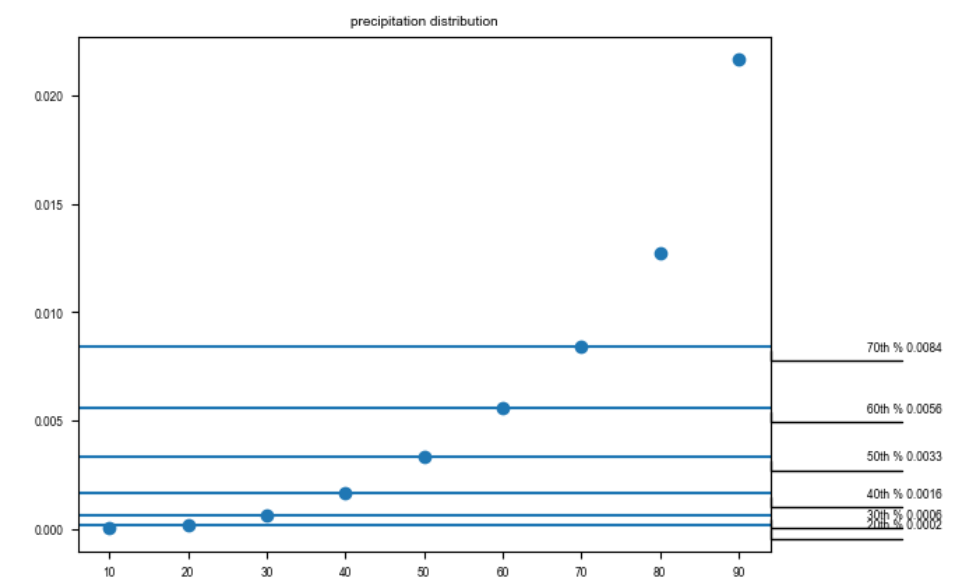

In [ ]:
bounds = dict(sfr = [0.0001, 1000, 1e-2], #lo, hi, initial values
fieswp = [0.5, 0.999, 0.7],
drn_k = [10, 10000, 1200],
fmp_vk = [0.0001, .01, 0.001],
hfb= [0.000001, 1000, 1000])
bounds

In [ ]:
for k in bounds.keys():
    c = pst.parameter_data.loc[:,'pargp'] == k
    print(c.sum(), k)
    pst.parameter_data.loc[c,['parlbnd','parubnd', 'parval1']] = bounds[k]

# for n, group in pst.parameter_data.groupby('pargp'):
#     if n in bounds.keys():
#         print(f"changing {n}")
#         pst.parameter_data.loc[group.index,['parlbnd','parubnd', 'parval1']] = bounds[n]
#     else:
#         print(f"not changing {n}")

In [ ]:
pst.parameter_data.pargp.unique()

In [ ]:
pst.parameter_data.parlbnd.min()

In [ ]:
pst.parameter_data.pargp.unique()

In [ ]:


# a = pp_cells * ml.dis.delr.array[0] * 3.0
# v = pyemu.geostats.ExpVario(contribution=1.0,a=a)
# gs = pyemu.geostats.GeoStruct(variograms=v,transform="log")
# gs.plot()

# pp_groups = pp_df.groupby("pargp").groups
# for pargp,par_names in pp_groups.items():
#     this_pp_df = pp_df.loc[par_names,:]
#     cov = gs.covariance_matrix(this_pp_df.x,this_pp_df.y,this_pp_df.index)
#     pyemu.helpers.first_order_pearson_tikhonov(pst,cov,reset=False,abs_drop_tol=0.2)

## set param bounds to those already set from pilot points (changing bounds only)

In [ ]:
print(f"these are the unique pargroups { pst.parameter_data.pargp.unique()}")

In [ ]:
bounds = dict(sy1 = [0.0001, 0.3], #lo, hi
ss1 = [1e-6, 1e-3],
ss2 = [1e-6, 1e-3],
ss3 = [1e-6, 1e-3],
ss4 = [1e-6, 1e-3],
ss5 = [1e-6, 1e-3],
ss6 = [1e-6, 1e-3],
vk1 = [1e-3, 1e-1],
vk2 = [1e-3, 1e-1],
vk3 = [1e-3, 1e-1],
vk4 = [1e-3, 1e-1],
vk5 = [1e-3, 1e-1],
vk6 = [1e-3, 1e-1],
hk1 = [1e-5, 10],
hk2 = [1e-5, 10],
hk3 = [1e-5, 10],
hk4 = [1e-5, 10],
hk5 = [1e-5, 10],
hk6 = [1e-5, 10],

             )
bounds

In [ ]:
for k in bounds.keys():
    c = pst.parameter_data.loc[:,'pargp'] == k
    print(c.sum(), k)
    pst.parameter_data.loc[c,['parlbnd','parubnd']] = bounds[k]
    # pst.parameter_data.loc[group.index,['parlbnd','parubnd']] = bounds[n]

# set iniitial values from last pest-run

In [ ]:
pst.parrep(os.path.join("C:\GSP\sv\model\pest_inputs\PEST_PP\pestaws", 'pest_ies.3.par.csv'), noptmax = 3)

In [ ]:
summary = pst.write_par_summary_table(filename="par.xlsx", report_in_linear_space = True)

In [ ]:
summary

In [ ]:
pst.parameter_data.groupby('pargp').max().sort_values('parubnd').head(50)

In [ ]:
pst.parameter_data

In [ ]:
pst.parameter_data.loc[pst.parameter_data.parlbnd==1.1e-10]

In [ ]:
assert (pst.parameter_data.parlbnd.min()>1.1e-10) & (pst.parameter_data.parlbnd.max()<1.1e+10), 'check parameter bounds. some have not yet been changed'

In [ ]:
pst.prior_information

# set observations with -999 as zero weights

In [ ]:
pst.observation_data

In [ ]:
print(f"number of non-zero observations before filtering for obs <=-999:\n {len(pst.nnz_obs_names)}")

pst.observation_data.loc[pst.observation_data.loc[:,'obsval']<=-999, 'weight'] = 0.0
print(f"after:\n {len(pst.nnz_obs_names)}")

In [ ]:
pst.observation_data.loc[pst.observation_data.loc[:,'obsval']<=-999].obgnme.value_counts()

In [ ]:
obs = pst.observation_data
# obs.loc[:,"standard_deviation"] = np.nan
hds_obs = [o for o in pst.nnz_obs_names if "oname:hds_" in o]
assert len(hds_obs) > 0
obs.loc[hds_obs,"standard_deviation"] = 0.5
# hdstd_obs = [o for o in pst.nnz_obs_names if "oname:hdstd_" in o]
# assert len(hdstd_obs) > 0
# obs.loc[hdstd_obs,"standard_deviation"] = 0.01

# sfr_obs = [o for o in pst.nnz_obs_names if "oname:sfr_" in o]
# assert len(sfr_obs) > 0
# # here we will used noise that is a function of the observed flow value so that 
# # when flow is high, noise is high.
# obs.loc[sfr_obs,"standard_deviation"] = 1.0 / (obs.loc[sfr_obs,"obsval"] * 0.2)
# # sfrtd_obs = [o for o in pst.nnz_obs_names if "oname:sfrtd_" in o]
# # assert len(sfrtd_obs) > 0
# # obs.loc[sfrtd_obs,"standard_deviation"] = 1.0 / (obs.loc[sfrtd_obs,"obsval"] * 0.2)
# obs.loc[obs.loc[:,"standard_deviation"]>50, "standard_deviation"] = 50

In [ ]:
summary_obs = pst.write_obs_summary_table(filename="obs.xlsx")

In [ ]:
summary_obs

Some **caution** is required here. Observation weights and how these pertain to history-matching *versus* how they pertain to generating an observation ensemble for use with `pestpp-ies` or FOSM is a frequent source of confusion.

 - when **history-matching**, observation weights listed in the control file determine their contribution to the objective function, and therefore to the parameter estiamtion process. Here, observation weights may be assigned to reflect observation uncertainty, the balance required for equal "visibility", or other modeller-defined (and perhaps subjective...) measures of observation worth.  
 - when undertaking **uncertainty analysis**, weights should reflect idealy the inverse of obseravtion error (or the standard deviation of measurement noise). Keep this in mind when using `pestpp-glm` or `pestpp-ies`. If the observations in the control file do not have error-based weighting then (1) care is required if using `pestpp-glm` for FOSM and (2) make sure to provide an adequately prepared observation ensemble to `pestpp-ies`.



## Distance Based Localization

This is industrial strength localization that combines the temporal localization from before with a distance-based cutoff between each spatially-distributed parameter type and each spatially-discrete observation.  In this way, we are defining a "window" around each observation and only parameters that are within this window are allowed to be conditioned from said observation.  It's painful to setup and subjective (since a circular window around each observation is a coarse approximation) but in practice, it seems to yield robust forecast estimates.

For the first time now, we will be using a fully-localized solve, meaning each parameter is upgraded independently.  This means PEST++IES has to run through the upgrade calculations once for each parameter - this can be very slow.  Currently, PESTPP-IES can multithread these calculations but the optimal number of threads is very problem specific.  Through testing, 3 threads seems to be a good choice for this problem (the PEST++IES log file records the time it takes to solve groups of 1000 pars for each lambda so you can test for your problem too).

In the next few cells we are going to make use of `flopy` and some of the metadata that `pyemu.PstFrom` recorded when constructing our PEST(++) setup to calculate distances between parmaters and observations. We will do this only for groundwater level observations.

In [ ]:


import flopy


In [ ]:
h = flopy.modflow.ModflowHob.load(os.path.join(ml.model_ws, 'SV_HOBS_11_18_2015.HOB'), ml)

In [ ]:
allmea = list()

for r in  ml.HOB.obs_data:
    cur = list()
    for k in r.time_series_data.obsname:
        cur.extend((k, r.column,  r.row))

    allmea.extend(cur)


In [ ]:
hds_df

In [ ]:
hobs = pd.DataFrame(np.array(allmea).reshape((-1,3)), columns = ['name', 'col', 'row'])



In [ ]:
heads_info =  hds_df.set_index(hds_df.obsnme.apply(lambda x: x.split(':')[-1]))
heads_info = heads_info.set_index(heads_info.index.str.upper())
heads_info


In [ ]:
hobs.row = hobs.row.astype(int)
hobs.col = hobs.col.astype(int)
hobs.name = hobs.name.astype(str)

# get x,y for cell of each obs
hobs.loc[:,'x'] = hobs.apply(lambda x: ml.modelgrid.xcellcenters[x.row,x.col], axis=1)
hobs.loc[:,'y'] = hobs.apply(lambda x: ml.modelgrid.ycellcenters[x.row,x.col], axis=1)

# group them for use later in identifying unique locations
hobs.loc[:,"xy"] = hobs.apply(lambda x: "{0}_{1}".format(x.row,x.col),axis=1)

hobs = pd.merge(hobs, heads_info,  left_on = 'name', right_index =True,)

hobs = hobs.set_index('obsnme')
hobs.head()

In [ ]:
# # start by getting the locations of observation sites
# # we will only do this for head obsevrations; other obs types in our PEST dataset arent applicable
# hobs = nz_obs.loc[nz_obs.oname.isin(['hds','hdsvd','hdstd'])].copy()
# hobs.loc[:,'i'] = hobs.obgnme.apply(lambda x: int(x.split('-')[-2]))
# hobs.loc[:,'j'] = hobs.obgnme.apply(lambda x: int(x.split('-')[-1]))
# # get x,y for cell of each obs
# hobs.loc[:,'x'] = hobs.apply(lambda x: gwf.modelgrid.xcellcenters[x.i,x.j], axis=1)
# hobs.loc[:,'y'] = hobs.apply(lambda x: gwf.modelgrid.ycellcenters[x.i,x.j], axis=1)
# # group them for use later in identifying unique locations
# hobs.loc[:,"xy"] = hobs.apply(lambda x: "{0}_{1}".format(x.x,x.y),axis=1)
# hobs.head()

We have the `x` and `y` coordinate of all grid and pilot point based parameters recorded in the `Pst` `parameter_data` section. Convenient.

In [ ]:
# get x,y for cell of each obs
par.loc[:,'x'] = np.nan
par.loc[:,'y'] = np.nan
par.loc[par.i.notnull(),'x'] = par.loc[par.i.notnull()].apply(lambda x: ml.modelgrid.xcellcenters[int(x.i),int(x.j)], axis=1)
par.loc[par.i.notnull(),'y'] = par.loc[par.i.notnull()].apply(lambda x: ml.modelgrid.ycellcenters[int(x.i),int(x.j)], axis=1)

In [ ]:
par.x=par.x.astype(float)
par.y=par.y.astype(float)
par.head()

In [ ]:
assert pst.observation_data.loc[pst.observation_data.obsnme.str.contains('m13-05')].weight.sum() ==0, f"need to fix these obs {pst.observation_data.loc[pst.observation_data.obsnme.str.contains('m13-05'), ['weight']]}"

First, create a `Matrix` for _all_ adjustable parameter _names_ and non-zero observations:

In [ ]:
spatial_loc = pyemu.Matrix.from_names(pst.nnz_obs_names,pst.adj_par_names).to_dataframe()
# set all elements to 1.0 to make sure all observation-parameter pairs are "active"
spatial_loc.values[:,:] = 1.0

In [ ]:
spatial_loc.shape

We have the `x` and `y` coordinate of all grid and pilot point based parameters recorded in the `Pst` `parameter_data` section. Convenient.

Now the tricky bit. We are going to go through each observation location and assign 0.0 to rows that correspond to _spatially distributed_ parameters that are further away than a specified cutoff distance (`loc_dist`). 

In [ ]:
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform
import numpy as np

par_loc = par.loc[:,['x','y']]
par_loc = par_loc.reindex(spatial_loc.columns)
display(par_loc.head())
obs_loc = hobs.loc[:,['x', 'y']]
obs_loc = obs_loc.reindex(index = spatial_loc.index)
display(obs_loc.head())
dist = distance.cdist( obs_loc.values,par_loc.values, 'euclidean')


In [ ]:
dist.shape == spatial_loc.shape

In [ ]:
spatial_loc.values[dist>2000] = 0

In [ ]:
spatial_loc

In [ ]:
assert spatial_loc.loc[spatial_loc.index.str.contains('m13-05')].shape[0] == 0, 'the m13-05 values need to be removed'

In [ ]:
# # the cutoff distance
# loc_dist = 2500.0 # arbitrary!
# # prepare a set of adjustable parameter names
# sadj = set(pst.adj_par_names)
# #select only spatial params to avoid applying to layer-wide multiplier parameters
# spatial_par = par.loc[par.x.notnull()].copy()
# # group obs by location
# xy_groups = hobs.groupby('xy').groups
# print('Number of observation sites:',len(xy_groups))
# # loop through each observation site and "blank out" correlation with parameters which are too far away
# for xy,onames in xy_groups.items():
#     # get the obs site x and y coords
#     oname = onames[0]
#     xx,yy = hobs.loc[oname,['x','y']]
#     # calculate distance from obs to parameters
#     spatial_par.loc[:,'dist'] = spatial_par.apply(lambda x: (x.x - xx)**2 + (x.y - yy)**2,axis=1).apply(np.sqrt)
#     # select pars that are too far from obs
#     too_far = spatial_par.loc[spatial_par.dist > loc_dist,"parnme"]
#     # keep only adjustable pars
#     too_far = too_far.loc[too_far.apply(lambda x: x in sadj)]
#     # assign zero to loc matrix for parameters that are too far from obs
#     spatial_loc.loc[onames, too_far] = 0.0


In [ ]:
pst.pestpp_options["ies_num_reals"] = 150  # starting with a real small ensemble!

In [ ]:
pyemu.Matrix.from_dataframe(spatial_loc).to_coo(os.path.join(template_ws,"spatial_loc.jcb"))


In [ ]:
pst.pestpp_options["ies_localizer"] = "spatial_loc.jcb"

A final consideration. 

Through localization, a complex parameter estimation problem can be turned into a series of independent parameter estimation problems. If large numbers of parameters are being adjusted, the parameter upgrade calculation process for a given lambda will require as many truncated SVD solves as there are adjustable parameters. This can require considerable numerical effort. To overcome this problem, the localized upgrade solution process in PESTPP-IES has been multithreaded; this is possible in circumstances such as these where each local solve is independent of every other local solve. The use of multiple threads is invoked through the `ies_num_threads()` control variable. It should be noted that the optimal number of threads to use is  problem-specific. Furthermore, it should not exceed the number of physical cores of the host machine on which the PESTPP-IES master instance is running.

However, the fully localized solve is still sssslllloooooowwwwwww.  So if you have heaps of parameters (>30,000 say) it may actually be faster to use more realizations rather than use localization in terms of wall time - more realizations will over come the issues related to spurious correlation simply by having more samples to calculate the empirical derivatives with...but this depends on the runtime of the forward model as well. As usual, the answer is: "It depends" - haha!

Just to make this notebook experience more enjoyable, lets limit the number of lambdas being tested (so that we only have to solve the fully localized solution once per iteration...):

# parameter covariance

In [ ]:
pst.parameter_data

In [ ]:
# # build the prior covariance matrix and store it as a compresed bianry file (otherwise it can get huge!)
# # depending on your machine, this may take a while...

# cov = pf.build_prior(fmt='coo', filename=os.path.join(template_ws,"prior_cov.jcb"))
# # and take a peek at a slice of the matrix
# try: 
#     x = cov.x.copy()
#     x[x==0] = np.NaN
#     plt.imshow(x[:1000,:1000])
# except:
#     pass

In [ ]:
# cov = pyemu.Cov.from_parameter_data(pst, sigma_range=4.)

In [ ]:
# cofdf = cov.to_dataframe()

In [ ]:
pst.model_command

In [ ]:
# pst.model_command = ['conda', 'conda activate gis_py_10', 'python forward_run.py']

pst.model_command = 'python forward_run.py'


In [ ]:
pst.model_command

### Other options that are usually a good idea

PESTPP-IES has heaps of options that can be brought to bare for any given problem but most of these have good default values.  However, two options that can be very important for highly nonlinear inverse problems are related to how and when to give up on realizations that are just not doing very well with respect to phi.  These lagging realizations can dominate the objective function and therefore influence the choice of lambda values, and, ultimately, the success of the PESTPP-IES analysis. These two options are `ies_bad_phi` and `ies_bad_phi_sigma`.  The first one, `ies_bad_phi` is an absolute tolerance on the maximum phi value that will be allowed for any realization in the ensemble at any point in the algorithm.  If a realization yields a phi greater than `ies_bad_phi`, it will be "dropped" from the ensemble.  This can be an important option if cells go dry and yield an enormous phi.  

The second option, `ies_bad_phi_sigma` is a relative tolerance on the phi of a realization vs the mean phi of all the realizations in the ensemble.  The "sigma" tells us standard deviation is involved in this option:  `ies_bad_phi_sigma` is the standard deviation "distance" from the mean phi that realizations are allowed to have before they are dropped.  For example, if the mean phi is 100 and standard deviation around this mean is 20, and `ies_bad_phi_sigma` = 2, then any realization with a phi greater than 100 + (2 * 20) = 140 is dropped.  This "adaptive" rejection filter adapts as the ensemble evolves across iterations, and, for highly nonlinear problems, this option can make a huge difference.  Values between 1.5 (more aggressive) and 2.5 (more tolerant) seem to work well...

In [ ]:
pst.pestpp_options["ies_bad_phi_sigma"] = 2.0 #middle ground value

In [ ]:
os.getcwd()

In [ ]:
# pyemu.os_utils.run('pestpp-ies pest_ies.pst', cwd = template_ws, verbose = True)

In [ ]:
# pst.control_data.pestmode = "estimation"

# set weights from existing weights

In [ ]:
pst_old = pyemu.Pst(os.path.join(template_ws, 'ies.pst'))

In [ ]:
assert pst.observation_data.index.isin(pst_old.observation_data.index).all()

In [ ]:
pst.observation_data.loc[pst_old.observation_data.index, 'weight'] = pst_old.observation_data.weight

pst.observation_data.loc[pst.observation_data.loc[:,'obsval']<=-999, 'weight'] = 0.0

In [ ]:
pst.control_data.noptmax = 5

# try with all ones for hk pars

In [ ]:
pst.parameter_data

### setting PEST++ options

Some things I like to add:

In [ ]:
pst.pestpp_options["svd_pack"] = "redsvd"
#pst.pestpp_options["forecasts"] = 
pst.pestpp_options["panther_agent_restart_on_error"] = True


In [ ]:
pst.enforce_bounds()

In [ ]:
pst.control_data.noptmax = -2

In [ ]:

pst.write(os.path.join(template_ws, 'ies.pst'),version=2)

In [ ]:
os.getcwd()

In [ ]:
pst.write(os.path.join('pest_ies.pst'),version=2)

# zip the folder

In [ ]:
shutil.make_archive(template_ws, 'zip', os.path.join(template_ws,template_ws) )

## Observation Weights

Of all the issues that we have seen over the years, none is greater than (in)appropriate weighting strategies.  It is a critical and fundamental component of any inverse problem, but is especially important in settings where the model is imperfect simulator and the observation data are noisy and there are diverse types of data.  Goundwater modeling anyone? 

In essence the weights will change the shape of the objective function surface in parameter space, moving the minimum around and altering the path to the minimum (this can be seen visually in the response surface notebooks).  Given the important role weights play in the outcome of a history-matching/data assimilation analysis, rarely is a weighting strategy "one and done", instead it is continuously revisited during a modeling analysis, based on what happened during the previous history-matching attempt.  

We are going to start off by taking a look at our current objective function value and the relative contributions from the various observation groups - these relative contributions are a function of the residuals and weights in each group. Recall that this is the objective function value with **initial parameter values** and the default observations weights.

First off, we need to get PEST to run the model once so that the objective function can be calculated. Let's do that now. Start by reading the control file and checking that NOPTMAX is set to zero:



In [ ]:
pst_out = pyemu.Pst(os.path.join(template_ws, 'ies.pst'))
pst_out.phi

In [ ]:
# check noptmax
pst.control_data.noptmax

Jeepers - that's large! Before we race off and start running PEST to lower it we should compare simualted and measured values and take a look at the components of Phi. 

Let's start with taking a closer look. The `pst.phi_components` attribute returns a dictionary of the observation group names and their contribution to the overal value of Phi. 

In [ ]:
phi  = pd.read_csv(r"C:\GSP\sv\model\update_2024\scripts\pestrunv4\pest_ies.base.rei", skiprows=[0,1], sep = '\s+')
print(phi.head())
phi.loc[:,'phi'] = (phi.loc[:,'Residual']*phi.Weight )**2

# phi.loc[:,'Test'] = phi.loc[:,'Weight']
# c = phi.Group=='aguacal'

# phi.loc[c,'Test'] = phi.loc[c,'Test']*4000
# c = phi.Group=='ken'
# phi.loc[c,'Test'] = phi.loc[c,'Test']*4000

# phi.loc[:,'phitest'] = (phi.loc[:,'Residual']**2)*phi.Test 

In [ ]:
sum([5.325e09 + 1.06e09 + 6.28e06])

In [ ]:
6.28e06/sum([5.325e09 + 1.06e09 + 6.28e06])

# looking at contributions to phi from streamflow

In [ ]:
r = phi.query("Name.str.contains('agua') & not Name.str.contains('raw')")

r.loc[:,'date'] = pd.to_datetime('1/1/1969') + pd.to_timedelta(r.Name.apply(lambda x:float(x.split(':')[-1])), unit = 'D')
ax = r.query("Measured>-10").plot.scatter(x = 'date', y = 'Measured', title = 'agua caliente', label = 'Measured')
r.query("Measured>-10").plot.scatter(x = 'date', y = 'Modelled', ax = ax, c = 'r',label = 'Modelled')
ax2 = ax.twinx()
r.query("Measured>-10").plot.scatter(x = 'date', y = 'phi', ax = ax2,  marker = 'o',label = 'Phi', c='None', edgecolors='k')

r = phi.query("Name.str.contains('ken') & not Name.str.contains('raw')")
r.loc[:,'date'] = pd.to_datetime('1/1/1969') + pd.to_timedelta(r.Name.apply(lambda x:float(x.split(':')[-1])), unit = 'D')
ax = r.query("Measured>-10").plot.scatter(x = 'date', y = 'Measured', title = 'kenwood', label = 'Measured')
r.query("Measured>-10").plot.scatter(x = 'date', y = 'Modelled', ax = ax, c = 'r',label = 'Modelled')
ax2 = ax.twinx()
r.query("Measured>-10").plot.scatter(x = 'date', y = 'phi', ax = ax2,  marker = 'o',label = 'Phi', c='None', edgecolors='k')

In [ ]:
phi.sum().phi

In [ ]:
phi.sort_values('phi').tail(100).set_index('Name').groupby('Group').plot.bar(y = 'phi', figsize = (15,6))

In [ ]:
tot = phi.drop(columns = 'Name').groupby('Group').sum()
tot

In [ ]:
tot.phi/tot.phi.sum()

In [ ]:
pst_out


Unfortunately, in this case we have too many observation groups to easily display (we assigned each individual time series to its own observation group; this is a default setting in `pyemu.PstFrom`). 

So let's use `Pandas` to help us sumamrize this information (note: `pyemu.plot_utils.res_phi_pie()` does the same thing, but it looks a bit ugly because of the large number of observation groups). To make it easier, we are going to just look at the nonzero observation groups:

In [ ]:
nnz_phi_components = {k:pst_out.phi_components[k] for k in pst_out.nnz_obs_groups} # that's a dictionary comprehension there y'all
nnz_phi_components

And while we are at it, plot these in a pie chart. 

If you wish, try displaying this with `pyemu.plot_utils.res_phi_pie()` instead. Because of the large number of columns it's not going to be pretty, but it gets the job done.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
phicomp = pd.Series(nnz_phi_components)
plt.pie(phicomp, labels=phicomp.index.values);
#pyemu.plot_utils.res_phi_pie(pst,);

Well that is certainly not ideal - phi is dominated by the SFR observation groups. Why? Because the magnitude of these observation values are much larger than groundwater-level based observations, so we can expect the residuals in SFR observations to be yuge compared to groundwater level residuals...and we assigned the same weight to all of them...

Now we have some choices to make.  In many settings, there are certain observations (or observation groups) that are of increased importance, whether its for predictive reasons (like some data are more similar to the predictive outputs from the modeling) or political - "show me obs vs sim for well XXX"...If this is the case, then it is probably important to give those observations a larger portion of the composite objective function so that the results of the history matching better reproduce those important observations.  

In this set of notebooks, we will use another very common approach: give all observations groups an equal portion of the composite objective function.  This basically says "all of the different observation groups are important, so do your best with all of them"

The `Pst.adjust_weights()` method provides a mechanism to fine tune observation weights according to their contribution to the objective function. (*Side note: the PWTADJ1 utility from the PEST-suite automates this same process of "weighting for visibility".*) 

We start by creating a dictionary of non-zero weighted observation group names and their respective contributions to the objective function. Herein, we will use the existing composite phi value as the target composite phi...


In [ ]:
pst_out = pyemu.Pst(os.path.join(template_ws, 'ies.pst'))
pst_out.phi

In [ ]:
frac_sfr_obs = pst.observation_data.query("obgnme=='kenwood_log' & weight>0").shape[0]/pst.observation_data.query("obgnme=='aguacal_log' & weight>0").shape[0]

In [ ]:
# create a dictionary of group names and weights
contrib_per_group = pst_out.phi / float(len(pst_out.nnz_obs_groups))
balanced_groups = {grp:contrib_per_group for grp in pst_out.nnz_obs_groups}
balanced_groups['hds'] = balanced_groups['hds']*10
# balanced_groups['kenwood_log'] = balanced_groups['kenwood_log']
balanced_groups['aguacal_log'] = balanced_groups['aguacal_log']*10

balanced_groups['kenwood_log'] = balanced_groups['aguacal_log']*frac_sfr_obs
# {x:v*3 if 'eside' in x else x:v for x,v in balanced_groups.items()}

balanced_groups = { key:(value*3 if 'eastside' in key
          else value) for key, value in balanced_groups.items() }

balanced_groups = { key:(value*3 if 'bay' in key
          else value) for key, value in balanced_groups.items() }

In [ ]:

phicomp_pre = pd.Series({k:pst_out.phi_components[k] for k in pst_out.nnz_obs_groups})


In [ ]:
# make all non-zero weighted groups have a contribution of 100.0
pst_out.adjust_weights(obsgrp_dict=balanced_groups,)

In [ ]:
phicomp = pd.Series({k:pst_out.phi_components[k] for k in pst_out.nnz_obs_groups})

In [ ]:


phoebe = phicomp.to_frame('post').join(phicomp_pre.to_frame('pre (even weighting)'))

# .plot.bar()

Let's take a look at how that has affected the contributions to Phi:

The next cell adds in a column to the `pst.observation_data` for checking purposes in subsequent tutorials. In practice, when you have lots of model outputs treated as "obserations" in the pest control file, setting a flag to indicate exactly which observation quantities correspond to actual real-world information can be important for tracking things through your workflow...

### Understanding Observation Weights and Measurement Noise

Let's have a look at what weight values were assigned to our observation groups:

In [ ]:
obs = pst_out.observation_data
for group in pst_out.nnz_obs_groups:
    print(group,f"{obs.loc[obs.obgnme==group,'weight'].max():,.1f}")

# here are the weights that should be set

| Name          | Value |
|:--------------|:------|
| hds           | 28    |
| aguacal_log   | 2783  |
| kenwood_log   | 1556  |

Ok, some variability there, and, as expected, the sfr flowout observations have been given a very low weight and the groundwater level obs have been given a very high weight - this is simply to overcome the difference in magnitudes between these two different data types.  All good...or is it?

In standard deterministic parameter estimation, only the relative difference between the weights matters, so we are fine there...but in uncertainty analysis, we often want to account for the contribution from measurement noise and we havent told any of the pest++ tools not to use the inverse of the weights to approximate measurement noise, and this is a problem because those weights we assigned have no relation to measurement noise!  This can cause massive problems later, especially is you are using explicit noise realizations in uncertainty analysis - Imagine how much SFR flow noise is implied by that tiny weight?  It's easy to see how negative SFR flow noise values might be drawn with that small of a weight (high of a standard deviation) #badtimes.   

So what can we do?  Well there are options.  An easy way is to simply supply a "standard_deviation" column in the `pst.observation_data` dataframe that will cause these values to be used to represent measurement noise.  

In [ ]:
pst_out.control_data.noptmax = 3

In [ ]:
pst_out.write(os.path.join(template_ws, "blast.pst"),version=2)

In [ ]:



mast = pd.read_csv(r"C:\GSP\sv\model\update_2024\scripts\master\pest_ies.0.par.csv").set_index('real_name')
temp = pd.read_csv(r"C:\GSP\sv\model\update_2024\scripts\pestrunv4\pest_ies.0.par.csv").set_index('real_name')

mast = mast.loc[['base']].T
temp = temp.loc[['base']].T

In [ ]:
j = mast.join(temp,rsuffix =  'temp' )
j.loc[:,'ratio'] = j.loc[:,'base']/j.loc[:,'basetemp']
bad = j.loc[j.ratio!=1]
pd.Series(bad.index.map(lambda x:x[0:3])).unique()

In [ ]:
### saving the new control file

In [ ]:
mast = pd.read_csv(r"C:\GSP\sv\model\update_2024\scripts\master\pest_ies.par_data.csv")
temp = pd.read_csv(r"C:\GSP\sv\model\update_2024\scripts\pestrunv2\pest_ies.par_data.csv")

In [ ]:
mast = mast.set_index('parnme').loc[:,['parval1', 'pargp']]
temp = temp.set_index('parnme').loc[:,['parval1']]

In [ ]:
j = mast.join(temp,rsuffix =  'temp' )

In [ ]:
j.loc[:,'ratio'] = j.loc[:,'parval1']/j.loc[:,'parval1temp']

In [ ]:
bad = j.loc[j.ratio!=1]

In [ ]:
bad.sort_values('ratio').groupby('pargp').mean()

In [ ]:
ml.dis.itmuni

In [ ]:
n = np.ones(vktemp.shape)*0.0033

In [ ]:
np.savetxt(r"C:\GSP\sv\model\update_2024\scripts\pestrunv2\pp2024_out\fmp_vk.txt", n)

In [ ]:
vkmast = np.genfromtxt(r"C:\GSP\sv\model\update_2024\scripts\master\pp2024_out\fmp_vk.txt")
vktemp = np.genfromtxt(r"C:\GSP\sv\model\update_2024\scripts\pestrunv3\pp2024_out\fmp_vk.txt")
vkmast[vkmast>1e10] = np.nan
vktemp[vktemp>1e10] = np.nan

In [ ]:
np.unique(vkmast.ravel())

In [ ]:
v = (vkmast/vktemp).ravel()
v = v[~np.isnan(v)]

In [ ]:
dd = vktemp[~np.isnan(vktemp)].ravel()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(np.arange(0,100,10), np.percentile(dd, np.arange(0,100,10)))

In [ ]:
summary = pst.write_par_summary_table(filename="par.tex", report_in_linear_space = True)

In [ ]:
summary

In [ ]:
mast = pyemu.Pst(r"C:\GSP\sv\model\update_2024\scripts\master\pest_ies.pst")

In [ ]:
dates = pd.date_range('12/1/1969', freq = 'M', periods  =586)
dates[-48:]

In [ ]:
586-24
